In [85]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import tqdm.notebook
import time
import DataGrabber
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('classic')

from utils import set_gpytorch_settings
#gpytorch.settings.max_cholesky_size
set_gpytorch_settings()

# Command in terminal to help with memory allocation
# set PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
# Kernel Imports
from gpytorch.kernels import PeriodicKernel
from custom_kernel import MinKernel, AR2Kernel, MaternKernel, LinearKernel
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval
from custom_kernel import noise_lower, noise_upper, noise_init

In [89]:
# Grab Data and create tensors
data_grab = DataGrabber.DataGrab(data_type='air_temperature') # year=["2020", "2021", "2022"])
wave_data = data_grab.grab_data()
y = torch.tensor(wave_data['atmp'].values.astype(np.float32)).cuda()
X = torch.tensor(wave_data['Time'].values.astype(np.float32)).cuda()
X = X.reshape(-1,1)
wave_data
X

ConnectionError: HTTPSConnectionPool(host='dods.ndbc.noaa.gov', port=443): Max retries exceeded with url: /thredds/dodsC/data/stdmet/46221/46221h2022.nc.dds (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001CDEA257850>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))

In [4]:
# Standardize Data
X = (X - X.min(0).values) / (X.max(0).values - X.min(0).values)
y = y.log()
y = y - torch.min(y)
y = 2 * (y / torch.max(y)) - 1
# Training vs test
from math import floor
#train_n = int(floor(0.9 * len(X)))

In [5]:
test_n = 800
train_x = X[test_n:].contiguous().cuda()
train_y = y[test_n:].contiguous().cuda()
test_x = X[-test_n:].contiguous().cuda()
test_y = y[-test_n:].contiguous().cuda()

In [6]:
X

tensor([[0.0000e+00],
        [5.6827e-05],
        [1.1365e-04],
        ...,
        [9.9989e-01],
        [9.9994e-01],
        [1.0000e+00]])

In [7]:
print(X.min())
print(X.max())
print(X.mean())

tensor(0.)
tensor(1.)
tensor(0.4991)


In [8]:
print(train_x.min())
print(train_x.max())
print(train_x.mean())

print(test_x.min())
print(test_x.max())
print(test_x.mean())

tensor(0.0228)
tensor(1.)
tensor(0.5105)
tensor(0.9772)
tensor(1.)
tensor(0.9886)


In [9]:
# Generate the train_loader and train_dataset
train_loader, train_dataset, test_loader, test_dataset = utils.create_train_loader_and_dataset(
    train_x, train_y, test_x, test_y)
data_compact = [train_x, train_y, test_x, test_y, train_loader, train_dataset, test_loader, test_dataset]

In [10]:
class StandardApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MeanFieldApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MAPApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def make_orthogonal_vs(model, train_x):
    mean_inducing_points = torch.randn(1000, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)
    covar_inducing_points = torch.randn(100, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)

    covar_variational_strategy = gpytorch.variational.VariationalStrategy(
        model, covar_inducing_points,
        gpytorch.variational.CholeskyVariationalDistribution(covar_inducing_points.size(-2)),
        learn_inducing_locations=True
    )

    variational_strategy = gpytorch.variational.OrthogonallyDecoupledVariationalStrategy(
        covar_variational_strategy, mean_inducing_points,
        gpytorch.variational.DeltaVariationalDistribution(mean_inducing_points.size(-2)),
    )
    return variational_strategy

class OrthDecoupledApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = make_orthogonal_vs(self, train_x)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class SpectralDeltaGP(gpytorch.models.ExactGP):
    # def __init__(self, train_x, train_y, kernel, num_deltas, noise_init=None):
    #     likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-11))
    #     likelihood.register_prior("noise_prior", gpytorch.priors.HorseshoePrior(0.1), "noise")
    #     likelihood.noise = 1e-2
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points)
        #variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        #super(SpectralDeltaGP, self).__init__(train_x, train_y, likelihood)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        #base_covar_module = kernel #gpytorch.kernels.SpectralDeltaKernel(num_dims=train_x.size(-1), num_deltas=num_deltas)
        #base_covar_module.initialize_from_data(train_x[0], train_y[0])
        self.covar_module = kernel#gpytorch.kernels.ScaleKernel(base_covar_module)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



#likelihood = gpytorch.likelihoods.GaussianLikelihood()
#model = SpectralMixtureGPModel(train_x, train_y, likelihood)

In [11]:
from gpytorch.kernels import SpectralMixtureKernel

num_deltas = 300
kernel_old = (
        #ScaleKernel(AR2Kernel()) +
        #ScaleKernel(MinKernel()*RBFKernel()) +
        #ScaleKernel(MinKernel())+
        #ScaleKernel(RBFKernel()) +
        #ScaleKernel(RBFKernel()*LinearKernel())+
        ScaleKernel(MaternKernel(nu=0.5)) +
        ScaleKernel(MaternKernel(nu=1.5)*PeriodicKernel(period_length_constraint=Interval(
            lower_bound=1e-4,
            upper_bound=0.1,
            initial_value=0.01
        ))) +
        ScaleKernel(MaternKernel(nu=1.5)*PeriodicKernel(period_length_constraint=Interval(
            lower_bound=0.05,
            upper_bound=0.3,
            initial_value=0.15
        ))) +
        ScaleKernel(MaternKernel(nu=1.5)*PeriodicKernel(period_length_constraint=Interval(
            lower_bound=0.25,
            upper_bound=1,
            initial_value=0.5
        ))) +
        ScaleKernel(gpytorch.kernels.SpectralDeltaKernel(
            num_dims=train_x.size(-1),
            num_deltas=num_deltas,
        )) +
        ScaleKernel(gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4))
        #ScaleKernel(RBFKernel()*PeriodicKernel())
        )

In [12]:
k4_spectral_base = SpectralMixtureKernel(num_mixtures=4)
k4_spectral_base.initialize_from_data_empspect(train_x, train_y)

C:\Users\dcaos\anaconda3\envs\GPs\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [77]:
import copy

k1 = copy.deepcopy(k4_spectral_base)

k2 = copy.deepcopy(k4_spectral_base) *PeriodicKernel(
    period_length_constraint=Interval(
    lower_bound=1/4000,
    upper_bound=5/(2*365),
    initial_value=1/(365*2))
)

k3 = ScaleKernel(MaternKernel(nu=1.5)*PeriodicKernel(
    period_length_constraint=Interval(
    lower_bound=1/4000,
    upper_bound=10/(2*365),
    initial_value=1/(2*365))
))

k4 = ScaleKernel(MaternKernel(nu=0.5))

kernel = (
	k1 + k3 + k4
    # not: ScaleKernel(k1+k2) since they all have spectral component
)


likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = Interval(noise_lower, noise_upper,initial_value=noise_init))



In [78]:
print(kernel.kernels[2].base_kernel.lengthscale)
# kernel.kernels

tensor([[0.4000]], grad_fn=<AddBackward0>)


In [79]:
num_ind_pts = 800 # Number of inducing points (128 is default for train_and_test_approximate_gp function)
num_epochs = 20

#m1, l1 = utils.train_and_test_approximate_gp(
#    StandardApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m2, l2 = utils.train_and_test_approximate_gp(
#     MeanFieldApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m3, l3 = utils.train_and_test_approximate_gp(
#     MAPApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m4, l4 = utils.train_and_test_approximate_gp(
#     OrthDecoupledApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m5, l5 = utils.train_and_test_approximate_gp(
#     SpectralDeltaGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_deltas)
# m6, l6 = utils.train_and_test_approximate_gp(
#     SpectralMixtureGPModel, kernel, *data_compact, num_epochs=100, num_ind_pts=num_deltas)
#l1 = gpytorch.likelihoods.GaussianLikelihood()
#m1 = SpectralMixtureGPModel(train_x, train_y, likelihood)
m1, l1 = utils.train_and_test_approximate_gp(
    StandardApproximateGP, kernel, *data_compact, num_epochs=num_epochs, num_ind_pts=num_ind_pts)
print(kernel.kernels[2].base_kernel.lengthscale)
m2, l2 = utils.train_and_test_approximate_gp(
    OrthDecoupledApproximateGP, kernel, *data_compact, num_epochs=num_epochs, num_ind_pts=num_ind_pts)
print(kernel.kernels[2].base_kernel.lengthscale)


Training StandardApproximateGP:   0%|          | 0/20 [00:00<?, ?it/s]

Test StandardApproximateGP MAE: 0.3162909150123596
--- 32.03645968437195 seconds ---
tensor([[2.1066]], grad_fn=<AddBackward0>)


Training OrthDecoupledApproximateGP:   0%|          | 0/20 [00:00<?, ?it/s]

Test OrthDecoupledApproximateGP MAE: 0.8485816717147827
--- 25.18919587135315 seconds ---
tensor([[2.1877]], grad_fn=<AddBackward0>)


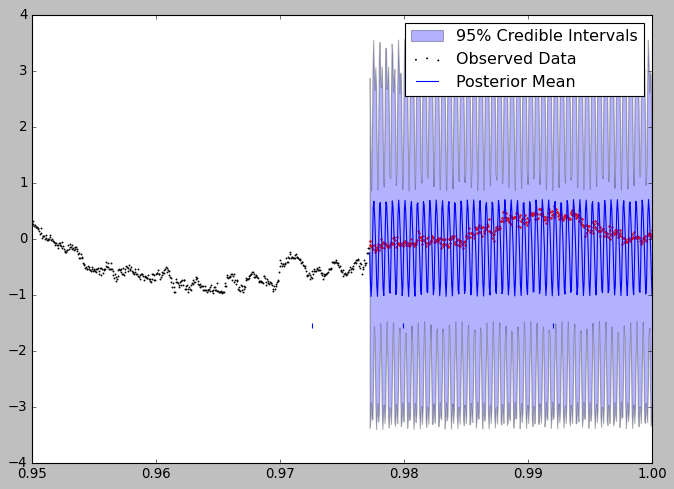

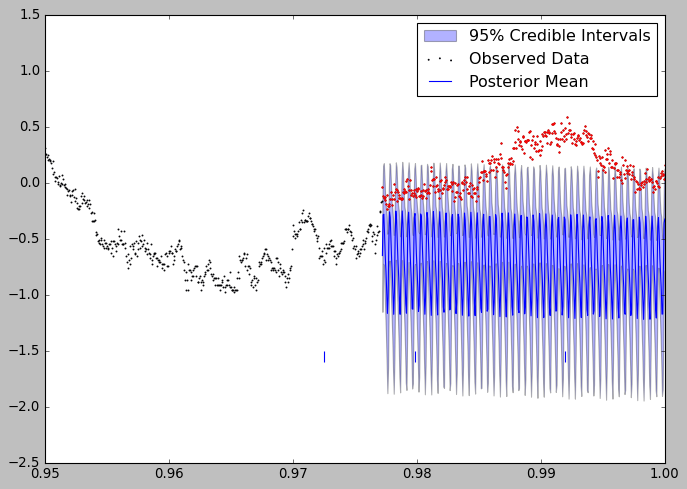

In [81]:
pairs = [[m1, l1],
        [m2, l2],]# [m3, l3],
#         [m4, l4], [m5, l5],
        #[m1, l1]]

for pair in pairs:
    model = pair[0]
    likelihood = pair[1]
    model.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x[:,0].detach().cpu().numpy(),
                    lower.detach().cpu().numpy(),
                    upper.detach().cpu().numpy(), alpha=0.3)
    # Plot training data as black stars
    ax.scatter(train_x[:,0].detach().cpu().numpy(), train_y.detach().cpu().numpy(), s=0.5)
    #ax.scatter(model.variational_strategy.inducing_points[:,0].detach().cpu().numpy(),
    #           np.zeros(500)+1, s=0.5)
    # Plot predictive means as blue line
    ax.plot(test_x[:,0].detach().cpu().numpy(), observed_pred.mean.detach().cpu().numpy(), 'blue')
    ax.scatter(
        test_x[:,0].detach().cpu().numpy(),
        test_y.detach().cpu().numpy(),
        s=1, color="red")
    ax.set_xlim(.95,1)
    #ax.set_xlim(0.65,0.75)
    ax.vlines(m1.variational_strategy.inducing_points.detach().cpu().numpy(), ymin = -1.6, ymax = -1.5)

    #ax.set_ylim([0, 1.5])
    #ax.patch.set_facecolor('green')
    #ax.patch.set_alpha(.1)
    ax.legend(["95% Credible Intervals", "Observed Data", "Posterior Mean"])

In [16]:
test_x.shape

torch.Size([400, 1])

In [17]:
train_x


tensor([[0.0228],
        [0.0229],
        [0.0229],
        ...,
        [0.9999],
        [0.9999],
        [1.0000]])

In [18]:
with torch.no_grad():
    m1(test_x)

In [19]:
# for i in range(len(m1.covar_module.kernels)):
#     print(m1.covar_module.kernels[i].outputscale)
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    9605 KB |    1047 MB |     775 GB |     775 GB |\n|       from large pool |    7656 KB |    1029 MB |     754 GB |     754 GB |\n|       from small pool |    1948 KB |      20 MB |      20 GB |      20 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |    9605 KB |    1047 MB |     775 GB |     775 GB |\n|       from large pool |    7656 KB |    1029 MB |

In [20]:
from utils import get_BIC

print(get_BIC(m1, likelihood, train_y, train_x))

RuntimeError: CUDA out of memory. Tried to allocate 4.33 GiB (GPU 0; 8.00 GiB total capacity; 4.78 GiB already allocated; 949.99 MiB free; 5.16 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
m1.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(m1(test_x))


In [ ]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(10, 7))

# Get upper and lower confidence bounds
lower, upper = observed_pred.confidence_region()
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x.detach().cpu().numpy(),
                lower.detach().cpu().numpy(),
                upper.detach().cpu().numpy(), alpha=0.3)
# Plot training data as black stars
ax.scatter(train_x.detach().cpu().numpy(), train_y.detach().cpu().numpy(), s=0.5)
# Plot predictive means as blue line
ax.plot(test_x.detach().cpu().numpy(), observed_pred.mean.detach().cpu().numpy(), 'blue')

ax.set_ylim([0, 1.5])
#ax.patch.set_facecolor('green')
#ax.patch.set_alpha(.1)
ax.legend(["95% Credible Intervals", "Observed Data", "Posterior Mean"])